<img src="Images/IMG-dirty-data.png" style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;">

Data processing of any kind (statistical analysis, machine learning, visualizations, ...) requires neatly and consistently structured data. In published dataset, much work has usually been done to make sure that all data points adhere to a common format and structure so that whatever processing we plan on doing can start right away. 

Often, however, and especially when we collect our own data, the datapoints can be a bit of a mess: Maybe we tapped different sources, which delivered data in different formats. Maybe some of our data points are incomplete. Maybe we have to convert some of our data to be able to process it. In a word: our data is dirty!

In this workshop, we will look at some selected techniques to deal with Dirty Data in a systematic and effective way. 

<img style="float: right; margin:5px 0px 0px 10px" src="Images/IMG-lego-logo.svg" alt="Lego-Logo" height="128" width="128">

The example data we will be handling are various facts and figures about Lego sets. It was collected by scraping the public product descriptions of www.lego.com. If you are interested in how you can collect data in this way, look out for our workshop on "Scraping and using web APIs with Python"!

In the course of this notebook, we will consolidate the data from two different sets of files, analyze its structure and format, clean up incomplete entries, and store the clean dataset for later use. This process is often called **Data Wrangling** or **Data Munging**.

### What you will learn in this workshop
- Importing data from inconsistent sources
- Cleaning up inconsistent or inconveniently formatted entries
- Dealing with missing values

We will use the Python data analysis and manipulation package [pandas](https://pandas.pydata.org/), but the presented strategies can be applied in any programming language and framework.



### Before we get started
There a few pandas-specific things you will see repeatedly in the examples that do not directly relate to the data cleaning techniques but are due to some of pandas quirks. We will discuss them here briefly:
#### The `DataFrame` object
Everything in pandas revolves around its core data structure: The `DataFrame`. You can think of a data frame as a big table that has a column for each variable and a row for each observation. Our first objective will be to get our data, which lives in various files, into a single `DataFrame` object! 

#### The `Series` object
Besides the `DataFrame` object, there is another structure to store strictly one-dimensional data (so either a single row or a single columns): the `Series` object. Pandas will usually be smart enough to figure out which one to use on its own, but sometimes we have to be give it a hint (for example when loading a single observation


#### Functions versus methods
Almost all of the analysis and manipulation will be accomplished by calling code built into pandas. You may be familiar with the concept of calling functions from a package or library, where you pass everything to the function and it then works its magic:

```python
head(dataframe)  # This is *not* how it works in pandas!
```

In pandas, however, you mostly call *methods* instead of functions, which simply means that they are called on the `DataFrame` itself:

```python
dataframe.head()  # The method is provided by the DataFrame object!
```

This approach is part of the *object-oriented paradigm* and has a number of advantages. If you are interested in hearing more about object-oriented programming and how it may help you to write more readable and robust code, let us know! 

#### The `inplace` keyword
Having heard about the difference between functions and methods, you may be wondering: What if our function or method has some kind of output? A function simply returns it:

```python
mean_value = mean(dataframe)  # This is *not* how it works in pandas
```

And the `DataFrame`'s methods usually do that, too:

```python
mean_value = dataframe.mean()  # An example method returning a value
```

In some cases, that means that a method returns a manipulated copy of the entire data frame:
```python
smaller_dataframe = dataframe.drop(columns='some_column_name')  # An example method returning a new manipulated copy of the dataframe
```

Sometimes we want a copy because we want to keep working both the manipulated and the original version. Often, however, we perform a series of manipulations and are only interested in the final version of the dataframe. So we do not want to create a bunch of copies along the way! 

For this use case, many methods provide the keyword `inplace`, which we can use to manipulate the dataframe in-place. In that case, no copy is made and the method returns nothing (the `None` object, to be precise), but the changes are applied to the original dataframe:

```python
dataframe.drop(columns='some_column_name', inplace=True)  # The column is removed from the original dataframe, no copy is made!
```

#### Accessing columns
As mentioned above, `DataFrame` objects usually contain multiple columns. You can access |individual columns in multiple ways. Two of the most convenient ones are the following:

```python
dataframe['column_name']  # Note the quotes: The column name is provided as a string!
dataframe.column_name     # Note the lack of quotes: The column name is treated like a field name!
```
These two methods are functionally totally equivalent. They each have their advantages. The square bracket notation, for example, lets you select multiple columns:
```python
dataframe[['column_name_1', 'column_name_2']]  # Note the nested square brackets: multiple column names are passed as a list!
```
You can only select a single column using the dot notation, but it is a bit more convenient to type and arguably more readable. There is no need to exclusively use only one or the other and you typically see both ways of accessing columns in a pandas project.



## Contents
<table style="width:256; border: 1px solid black; display: inline-block">
  <tr style="background-color:white">
    <td  style="text-align:right" width=64px><img src="Images/IMG-csv-in.png" style="float:left"></td>
      <td style="text-align:left" width=128px>
          <a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#import_data'>Import data</a>
      </td>
  </tr>
  <tr style="background-color:whitesmoke">
    <td style="text-align:right"><img src="Images/IMG-magnifying-glass.png" style="float:left"></td>
    <td style="text-align:left" width=128px><a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#analyze_data'>Analyze data</a>
      </td>
  </tr>
    <tr style="background-color:white">
    <td style="text-align:right"><img src="Images/IMG-broom.png" style="float:left"></td>
    <td style="text-align:left" width=128px><a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#clean_data'>Clean data</a>
        </td>
    </tr>
    <tr style="background-color:whitesmoke">
    <td style="text-align:right"><img src="Images/IMG-csv-out.png" style="float:left"></td>
    <td style="text-align:left" width=128px><a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#save_data'>Save data</a>
        </td>
  </tr>
</table>


<a id='import_data'></a><div><img src="Images/IMG-csv-in.png" style="float:left;background-color:white"> <h2 style="position: relative; top: 6px">1. Import data</h2>
<p style="position: relative; top: 10px">
Our data does not come in a single file. Instead, the data of every Lego set were saved in their own separate file. Even worse, the files came from different sources. We cannot be sure that they contain the same kinds of data and even if they do, they might use different formats. At the very least, the fact that the filenames apparently follow different naming conventions should make us suspicious. Let's investigate!

First, we need to load all the individual files and consolidate them in a dataframe. Since there are two different kinds of files, we will start by creating two separate dataframes (one for each set of files). Afterwards, we will homogenize the two dataframes and merge them into a single one.

In [ ]:
import pandas as pd
from pathlib import Path

"""
Each file will eventually be a row in our consolidated dataframe.
It is *much* faster to build a dataframe from a list of rows, than to append rows to a dataframe.
"""

source1 = []  # Data from all the files whose file name starts with "set"
source2 = []  # Data from all the files consisting of the product ID and the country code

for file in Path("Data").glob("*.json"):
    new_file = pd.read_json(file, typ="series")
    if file.name.startswith("set"):
        source1.append(new_file)
    else:
        new_file["prod_id"], new_file["country"] = file.stem.split("_")
        source2.append(new_file)

# Create dataframes by concatenating the rows
source1 = pd.concat(source1, axis=1).T
source2 = pd.concat(source2, axis=1).T

Since the two sets of files came from different sources, we need to make sure that they contain the same kinds of data. The first thing we should check is if there are any columns that are not part of *both* dataframes:

In [ ]:
print(f"Source 1 contains the following columns that are not part of source 2: {set(source1.columns) - set(source2.columns)}")
print(f"Source 2 contains the following columns that are not part of source 1: {set(source2.columns) - set(source1.columns)}")

Source 1 contains the following columns that are not part of source 2: {'set', 'play_star_rating', 'theme', 'prod_short_desc', 'val_star_rating', 'star_rating'}
Source 2 contains the following columns that are not part of source 1: {'prod_desc', 'play_rating', 'overall_rating', 'theme_name', 'value_rating', 'set_name'}


There are a few columns that are not in both sets. Fortunately, they seem to be just different names for the same kinds of data. We can therefore simply rename the respective columns:

In [ ]:
source1.rename({"set": "set_name", "theme": "theme_name", "val_star_rating": "value_rating", "star_rating": "overall_rating", "play_star_rating": "play_rating"}, axis="columns", inplace=True)
source2.rename({"prod_desc": "prod_short_desc"}, axis="columns", inplace=True)

In [ ]:
print(f"Source 1 contains the following columns that are not part of source 2: {set(source1.columns) - set(source2.columns)}")
print(f"Source 2 contains the following columns that are not part of source 1: {set(source2.columns) - set(source1.columns)}")

Source 1 contains the following columns that are not part of source 2: set()
Source 2 contains the following columns that are not part of source 1: set()


Now that we have homogenized the structure, we can merge the two dataframes:

In [ ]:
dataset = pd.concat([source1, source2]).reset_index(drop=True)
dataset.head()

,ages,list_price,num_reviews,piece_count,play_rating,prod_short_desc,prod_id,prod_long_desc,review_difficulty,set_name,overall_rating,theme_name,value_rating,country
0,8-14,19.99,2.0,171.0,5.0,Call in the powerful Dozer Compactor!,42071.0,Capture the awesome power of a real-life dozer...,Challenging,Dozer Compactor,5.0,Technic,5.0,US
1,7-14,54.8878,5.0,406.0,5.0,Power up for battle against the Lex Luthor™ Mech!,76097.0,Team up with the Justice League heroes to grab...,Average,Lex Luthor™ Mech Takedown,4.8,DC Comics™ Super Heroes,4.8,BE
2,6+,12.1878,1.0,115.0,4.0,Decorate and customize your castle!,40307.0,Make your castle fit for a princess with this ...,Easy,Castle Interior Kit,5.0,Disney™,4.0,ES
3,5-12,37.6971,None,297.0,None,Race after the crook and avoid the mountain ro...,60172.0,Pick up your badge and join the LEGO® City Mou...,None,Dirt Road Pursuit,None,City,None,PL
4,5-12,55.986,16.0,337.0,3.6,"Hop on, there’s so much to see with the LEGO® ...",60154.0,Join the other passengers for a quick and easy...,Easy,Bus Station,3.3,City,2.7,GB


Woohoo! All of our Lego sets are in the same data structure!

---

<a id="analyze_data"></a><div><img src="Images/IMG-magnifying-glass.png" style="float:left;background-color:white"> <h2 style="position: relative; top: 6px">2. Analyze data</h2>

<p style="position: relative; top: 10px">
With all data now gathered in a single dataframe, we can get some basic statistics on our (uncleaned) dataset:
</p>

In [ ]:
dataset.describe()

,ages,list_price,num_reviews,piece_count,play_rating,prod_short_desc,prod_id,prod_long_desc,review_difficulty,set_name,overall_rating,theme_name,value_rating,country
count,12143,12143.0000,10537.0,12143.0,10385.0,11766,12143.0,12143,10112,12143,10537.0,12140,10365.0,12143
unique,31,733.0000,86.0,447.0,30.0,731,1349.0,989,5,741,27.0,40,33.0,21
top,6-12,12.1878,2.0,1.0,5.0,Put the heat on the shark army with Kai’s Fire...,41607.0,Help Lloyd to save Nomis and Nancy from Garmad...,Easy,Rey,5.0,Star Wars™,5.0,US
freq,1476,694.0000,1470.0,337.0,2199.0,42,36.0,42,4196,62,2718.0,1377,1630.0,811


We can see that the columns contain up to 12143 entries. Some of the columns contain numeric values, some contain strings. A few variables are categorical with only a small number of unique levels.

Let's visualize some of the columns to get a general "feel" for the dataset:

<AxesSubplot: >

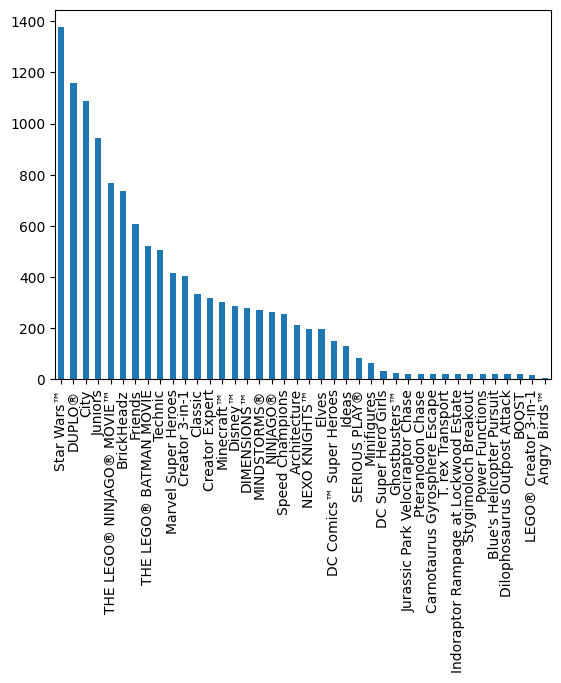

In [ ]:
dataset.theme_name.value_counts().plot.bar()

<AxesSubplot: title={'center': 'list_price'}, xlabel='theme_name'>

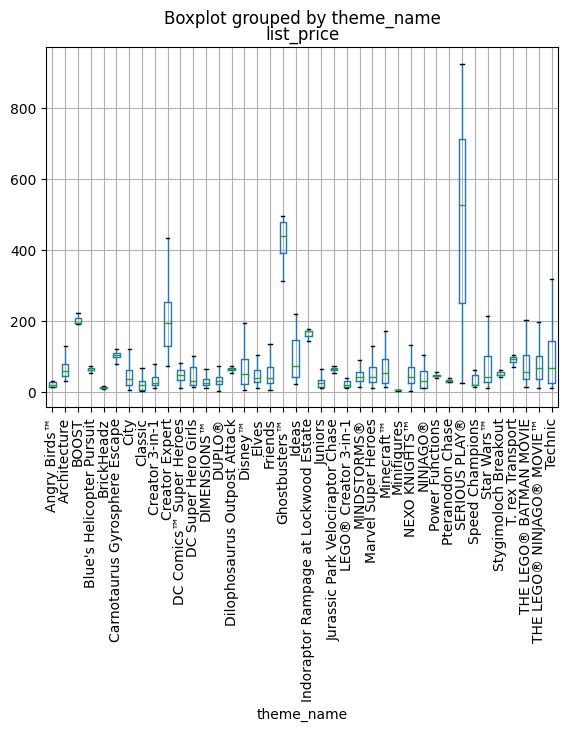

In [ ]:
dataset.boxplot(column='list_price', by='theme_name', rot=90, showfliers=False)

<AxesSubplot: title={'center': 'list_price'}, xlabel='country'>

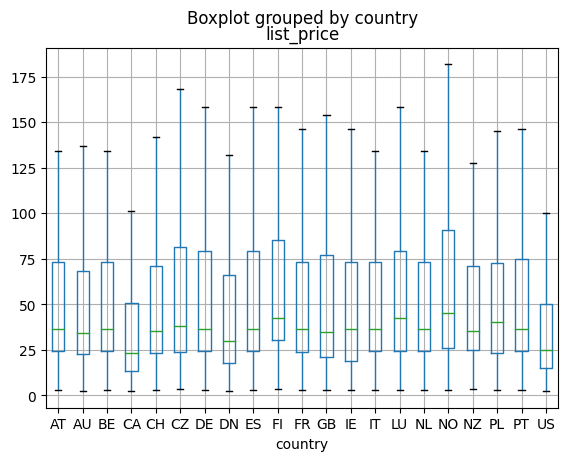

In [ ]:
dataset.boxplot(column='list_price', by='country', showfliers=False)

Now that we have a basic idea of our dataset, we can start looking for inconsistencies. The first thing we should do is check for duplicated rows:

In [ ]:
dataset.duplicated().any()

True

We have some duplicates in our dataset! We will remove them in the cleaning step.

Next, let's check for missing entries:

In [ ]:
dataset.isna().any()

ages                 False
list_price           False
num_reviews           True
piece_count          False
play_rating           True
prod_short_desc       True
prod_id              False
prod_long_desc       False
review_difficulty     True
set_name             False
overall_rating        True
theme_name            True
value_rating          True
country              False
dtype: bool

There are indeed missing entries in various columns. Filling missing entries requires case-by-case analysis, which will do during the cleaning step.

There is, of course, a *lot* more to explore (in fact, we offer an entire workshop on Exploratory Data Analysis), but let us move on for now and start cleaning our data!

---

<a id="clean_data"></a><div><img src="Images/IMG-broom.png" style="float:left;background-color:white"> <h2 style="position: relative; top: 6px">3. Clean data</h2>

Let's summarize what kind of dirt we found during the analysis step:

- Some rows are duplicated
- The column `ages` is inconveniently coded
- Some entries are missing

In this step, we will work through this list and clean up the mess.

<h3> 3.1 Duplicated rows</h3>

We already now from the analysis that there are some duplicated rows. Let's get a little more specific here and find out how many rows exactly are duplicated:

In [ ]:
num_duplicated = dataset.duplicated().sum()
print(f"There are {num_duplicated} duplicated rows, which is {num_duplicated/dataset.shape[0]:.2f} % of the total data.")

There are 716 duplicated rows, which is 0.06 % of the total data.


In some contexts, duplicated rows in a dataset can be meaningful (e.g. when sampling an unchanging source repeatedly). In this case, the duplicates are most likely due to our two different data sources, which have some overlap in the scraped Lego sets. We can therefore simply drop the duplicates without losing any information;

In [ ]:
dataset.drop_duplicates(inplace=True)

<h3> 3.2 Convert inconvenient format </h3>

Let's take a closer look at the column `'ages'`:

In [ ]:
dataset.ages.unique()

array(['8-14', '7-14', '6+', '5-12', '4-7', '2-5', '9+', '6-12', '10+',
       '8+', '9-14', '16+', '7-12', '4+', '1½-5', '1½-3', '12+', '6-14',
       '8-12', '4-99', '10-21', '9-16', '10-16', '14+', '12-16', '11-16',
       '9-12', '5+', '7+', '10-14', '5-8'], dtype=object)

The encoding of the age range is fairly inconvenient for further analysis because it hides two pieces of information (minimum age and maximum age) in a single string. This makes it unnecessarily difficult to, for example, obtain only the subset of entries that are appropriate for age 13 and above.

We can try to fix this by introducing two new columns: `'age_min'` and `'age_max'`. We can get their respective values by parsing the existing entries. If no maximum value is given (e.g. in `5+`), we will assume `99` (which is a *de-facto* industry standard). First, we homogenize the format of the entries in the column `'ages'`:

In [ ]:
dataset.ages = dataset.ages.str.replace('+','-99', regex=False)
dataset.ages = dataset.ages.str.replace('½', '.5')
dataset.ages.unique()

array(['8-14', '7-14', '6-99', '5-12', '4-7', '2-5', '9-99', '6-12',
       '10-99', '8-99', '9-14', '16-99', '7-12', '4-99', '1.5-5', '1.5-3',
       '12-99', '6-14', '8-12', '10-21', '9-16', '10-16', '14-99',
       '12-16', '11-16', '9-12', '5-99', '7-99', '10-14', '5-8'],
      dtype=object)

Now that all strings have the same format, we can easily split them into the lower and upper boundary and move them into new columns and converting the strings to numbers. Afterwards, we can safely drop the now redundant column `'ages'`.

In [25]:
dataset[['age_min', 'age_max']] = dataset.ages.str.split('-', expand=True).astype("float")
dataset.drop(columns='ages', inplace=True)
dataset.head()

,list_price,num_reviews,piece_count,play_rating,prod_short_desc,prod_id,prod_long_desc,review_difficulty,set_name,overall_rating,theme_name,value_rating,country,age_min,age_max
0,19.99,2.0,171.0,5.0,Call in the powerful Dozer Compactor!,42071.0,Capture the awesome power of a real-life dozer...,Challenging,Dozer Compactor,5.0,Technic,5.0,US,8.0,14.0
1,54.8878,5.0,406.0,5.0,Power up for battle against the Lex Luthor™ Mech!,76097.0,Team up with the Justice League heroes to grab...,Average,Lex Luthor™ Mech Takedown,4.8,DC Comics™ Super Heroes,4.8,BE,7.0,14.0
2,12.1878,1.0,115.0,4.0,Decorate and customize your castle!,40307.0,Make your castle fit for a princess with this ...,Easy,Castle Interior Kit,5.0,Disney™,4.0,ES,6.0,99.0
3,37.6971,None,297.0,None,Race after the crook and avoid the mountain ro...,60172.0,Pick up your badge and join the LEGO® City Mou...,None,Dirt Road Pursuit,None,City,None,PL,5.0,12.0
4,55.986,16.0,337.0,3.6,"Hop on, there’s so much to see with the LEGO® ...",60154.0,Join the other passengers for a quick and easy...,Easy,Bus Station,3.3,City,2.7,GB,5.0,12.0


Now we can easily subset our dataset based on arbitrary age ranges:

In [ ]:
dataset[dataset.age_min < 9]

In [ ]:
dataset[dataset.age_max > 12]

In [ ]:
dataset[(dataset.age_min > 7) & (dataset.age_max < 15)]

<h3> 3.3 Missing values</h3>

As mentioned above, filling in missing values is a case-by-case process. This process can become quite complex and is know as [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)). Many methods and techniques can be applied to "fill in the gaps" in our data, but before we dive into it ourselves, we need to keep two things in mind:

__Imputed data is not real data!__
No matter how sophisticated our imputation technique is, we need to remind ourselves that the data we are filling in are *not* real-world data! That means, for example, that we should never validate models on datasets containing imputed values. We should also be very carefule when imputing values of a variable that will be used as the target variable in regression or classification model.

__Beware of bias!__
Imputation is data manipulation and as such almost always introduces bias into the dataset. However, not imputing missing values means we would have to drop all data points that are missing values, which may also introduce bias.

In practice, we need to carefully consider our respective scenario, weigh the damage of discarding data versus introducing artificial data, and how intrusive our chosen imputation method may be. 

One important factor to consider is the proportion of missing values. Any imputation needs to be properly supported by a sufficient number of actual data points. We therefore should not try to impute 5000 missing values from only 100 known values. What exactly constitues "enough" support, however, cannot be universally stated.

Let's check our dataset and calculate the proportion of missing values for each column:

In [ ]:
dataset.isna().sum() / dataset.shape[0]

Evidently, we have more than 80 % existing values in each column, which we will consider sufficient support to impute the remaining missing values for this exercise. Therefore, we will not have to drop any columns.

Next, we will go through the columns containing missing values and try to impute them.

<h4>3.3.1 Number of reviews</h4>

The column `num_reviews` contains the number of reviews available for each set. There are quite a few missing values:

In [ ]:
dataset.num_reviews.isna().sum()

Let's find out which values *are* present in the column:

In [ ]:
print(f"Min value: {dataset.num_reviews.min()}")
print(f"Max value: {dataset.num_reviews.max()}")
print(f"Mean value: {dataset.num_reviews.mean():.2f}")
print(f"Standard deviation: {dataset.num_reviews.std():.2f}")

Interesting find: The number of reviews is apparently only recorded when it is greater than 0! We can therefore deduce that the missing values indicate sets that have 0 reviews. 

In this case, we can thus simply replace the missing values with the value 0:

In [ ]:
dataset.num_reviews.fillna(0, inplace=True)

Let's check the statistics again to see how our imputation affected them:

In [ ]:
print(f"Min value: {dataset.num_reviews.min()}")
print(f"Max value: {dataset.num_reviews.max()}")
print(f"Mean value: {dataset.num_reviews.mean():.2f}")
print(f"Standard deviation: {dataset.num_reviews.std():.2f}")

We can see that the mean value was affected by our imputation, meaning we shifted the distribution of this variable to the left. In this case, that makes perfect sense given that the missing values were not considered before and the mean is now actually more accurate than it was before. In general, however, we have to be very mindful that imputations may introduce distortions of the distribution that are not acceptable!

#### 3.3.2 Difficulty

The difficulty of each set is stored in the column `'review_difficulty'`. Let's take a look at the unique levels of this categorical variable and how it is distributed:

In [ ]:
dataset.review_difficulty.unique()

In [ ]:
dataset.review_difficulty.hist()

It is reasonable to assume that the piece count has an impact on the difficulty level of a set. So let us also look at the distribution of the piece count broken down by the difficulty level:

In [ ]:
dataset.boxplot(column='piece_count', by='review_difficulty')

Interesting! We notice fairly distinct distributions for each difficulty level. In other words: Given a specific piece count, the difficulty levels are not equally likely! 
We may also suspect a similar relationship regarding the list price:

In [ ]:
dataset.boxplot(column='list_price', by='review_difficulty')

Indeed, the list price shows a similar pattern. 

How about the minimum age?

In [ ]:
dataset.boxplot(column='age_min', by='review_difficulty')

Once again, a distinct pattern emerges!


Our brief analysis here suggests that knowing the minimum age, the list price and the number of pieces, we should be able to make a pretty good guess of what the difficulty would be!

To make that guess, we will use Naive Bayes classifier. In a nutshell, this classifier identifies the most likely difficulty level given a minimum age, piece count and list price. While the theory behind this goes beyond the scope of this notebook, let us know if you are interested in this topic and we would be happy to offer a whole workshop on this!

For now, let it suffice to say that our classifier needs to be trained by fitting it to the known pairs of [minimum age, piece count, list price] and corresponding difficulty level. Once it is fitted, the classifier can predict the difficulty level for any combination of minimum age, piece count, and list price.

We will use the package [scikit-learn](https://scikit-learn.org/) to import an implementation of the Naive Bayes classifier:

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Fit the classifier using known pairs of ['piece_count', 'list_price'] and 'review_difficulty'
imputer = GaussianNB().fit(X=dataset.dropna(subset=['review_difficulty'])[['age_min', 'piece_count', 'list_price']], y=dataset.review_difficulty.dropna())

# Use the fitted classifier to predict a difficulty for all entries
dataset['predicted_difficulty'] = imputer.predict(dataset[['age_min', 'piece_count', 'list_price']])

# Fill in the missing difficulty values form the predicted levels
dataset.review_difficulty.fillna(dataset.predicted_difficulty, inplace=True)

# Drop the column 'predicted_difficulty' since it is no longer needed
dataset.drop(columns='predicted_difficulty', inplace=True)

<h4>3.3.3 Theme name</h4>

There is only a very small number of missing values in the column `'theme_name'`. Let's look at those entries more closely:

In [ ]:
dataset[dataset['theme_name'].isna()]

In this case, there are so few entries that we can even consider going back to the data collection stage to find the missing information!

By simply searching for the listed sets on the [Lego website](www.lego.com) ourselves, we can find out the corresponding themes and fill them in manually:

In [ ]:
dataset.at[671, 'theme_name'] = "Speed Champions"
dataset.at[724, 'theme_name'] = "Friends"
dataset.at[1432, 'theme_name'] = "Minifigures"

#### 3.3.4 Short descriptions

A few short descriptions are missing from the dataset. Spot checking the affected entries reveals that these sets indeed do not have short descriptions. Therefore, we should replace the missing values with empty strings.

In [ ]:
dataset.prod_short_desc.fillna("", inplace=True)

<h4>3.3.4 Ratings</h4>

The Lego sets are rated by the website users on three different interval scales from 1 (worst) to 5 (best): The *play experience*, the perceived *value*, and the *overall* rating. The columns `play_rating`, `value_rating`, and `overall_rating` contain the respective average rating for each set. Some sets have not been rated on every scale, so some ratings are missing. Let us take a look at the descriptive statistics of the existing ratings. This time, we will use the convenient method `describe()` on the column. Because `describe()` gives us different information depending on the type of the column, we need to convert the columns to a numeric type first:

In [ ]:
dataset[['play_rating', 'value_rating', 'overall_rating']].astype("float64").describe()

We should note that if a set is missing a rating, it is not necessarily missing *all* ratings. 

A reasonable assumption could be that in the absence of a play or value rating, the overall rating is a fairly good stand-in for it. We therefore start by filling in the overall rating for the missing play and/or value rating, if available:

In [ ]:
dataset.play_rating.fillna(dataset["overall_rating"], inplace=True)
dataset.value_rating.fillna(dataset["overall_rating"], inplace=True)

In [ ]:
dataset[['play_rating', 'value_rating', 'overall_rating']].astype("float64").describe()

As we can see, we were able to fill in a few values without affecting the statistics too much. However, there are still quite a few entries without any ratings at all! 

We should now try to find a best guess for which value to use for each of the missing entries. Our guess could be based on only the univariate statistics of each individual column (e.g. the mean or mode), but that would possibly distort multivariate patterns in the dataset. What if, for example, sets with a large number of pieces tend to have a higher value rating? Ideally, we would try to consider and leverage these relationships between the columns using regression models or *k*-Nearest Neighbor donors. However, this takes us deeper down the rabbit hole of imputation, which is a field in its own right. If you are interested in an advanced workshop on this topic, feel free to contact us so we know that this is of interest!

For the purposes of this notebook, we will simply choose random values for the ratings, drawn from the the existing values. That way we do not distort the existing univariate distribution of each rating, although we possibly weaken existing multivariate patterns in the dataset.

In [ ]:
import random

existing_values = dataset[['play_rating', 'value_rating', 'overall_rating']].dropna().values

def fill_in_random_existing_value(entry):
    if entry.isna().any():
        entry = random.choice(existing_values)
    return entry
    
dataset[['play_rating', 'value_rating', 'overall_rating']] = dataset[['play_rating', 'value_rating', 'overall_rating']].apply(fill_in_random_existing_value, axis='columns')

<a id="save_data"></a><div><img src="Images/IMG-csv-out.png" style="float:left;background-color:white"> <h2 style="position: relative; top: 6px">4. Save data</h2>

<p style="position: relative; top: 10px">
Our dataset is now fairly tidy! To save us the trouble of going through the entire process again every time we want to do something with this dataset, we can save the cleaned up version to a CSV file.

```python
some_dataFrame.to_csv(filename)
```
</p>


In [ ]:
dataset.to_csv('tidy_lego_sets.csv')


<p style="font-weight:bold">Congratulations! You have brought order to our messy pile of Legos.</p>

<img src="Images/IMG-lego-messy-to-tidy.png" width="1080px" style="float:center;background-color:white"/>


<a style="float:left;background-color:black;color:white;text-decoration:none;padding:4px 6px;font-family:-apple-system, BlinkMacSystemFont, &quot;San Francisco&quot;, &quot;Helvetica Neue&quot;, Helvetica, Ubuntu, Roboto, Noto, &quot;Segoe UI&quot;, Arial, sans-serif;font-size:12px;font-weight:bold;line-height:1.2;display:inline-block;border-radius:3px" href="https://unsplash.com/@egnaro?utm_medium=referral&amp;utm_campaign=photographer-credit&amp;utm_content=creditBadge" target="_blank" rel="noopener noreferrer" title="Download free do whatever you want high-resolution photos from Rick Mason"><span style="display:inline-block;padding:2px 3px"><span style="display:inline-block;padding:2px 3px">Photo by Rick Mason</span></a><a style="float:right;background-color:black;color:white;text-decoration:none;padding:4px 6px;font-family:-apple-system, BlinkMacSystemFont, &quot;San Francisco&quot;, &quot;Helvetica Neue&quot;, Helvetica, Ubuntu, Roboto, Noto, &quot;Segoe UI&quot;, Arial, sans-serif;font-size:12px;font-weight:bold;line-height:1.2;display:inline-block;border-radius:3px" href="https://www.reddit.com/r/lego/comments/7mhq2b/finished_kind_of_organizing_my_spare_lego_pieces/" target="_blank" rel="noopener noreferrer" title="Download free do whatever you want high-resolution photos from Rick Mason"><span style="display:inline-block;padding:2px 3px"></span><span style="display:inline-block;padding:2px 3px">Photo by rexorhun</span></a>


<div>Icons made by <a href="https://www.flaticon.com/authors/swifticons" title="Swifticons">Swifticons</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a></div>
<div>Notebook by <a href="mailto:simon.stone@dartmouth.edu?Subject=Workshop%20Dirty%20Data" target="_top">Simon Stone</a></div>